In [29]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#method : scaling, log transformation, cube Root normalization, Box-Cox transformation
from scipy.stats import skew 
from scipy.stats import boxcox

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [32]:
df = pd.read_csv('heart_2020_cleaned.csv')
df.shape

(319795, 18)

In [33]:
df = df.drop_duplicates()
df.shape

(301717, 18)

In [34]:
# noise 처리
df = df[(df['BMI'] < 80) & (df['SleepTime'] != 24)]
df.shape

(301653, 18)

In [35]:
def yesno_tolabel(x):
    if (x == 'Yes') | (x == 'Yes (during pregnancy)') :
        return 1
    else:
        return 0

In [36]:
sex_map = {'Female' : 0, 'Male' : 1}
health_map = {'Excellent' : 4, 'Very good' : 3, 'Good' : 2, 'Fair' : 1, 'Poor' : 0}
diabetic_map = {'Yes' : 2, 'Yes (during pregnancy)' : 2, 'No, borderline diabetes' : 1, 'No' : 0}
age_map = {'18-24' : 20, '25-29' : 25, '30-34' : 30, '35-39' : 35, '40-44' : 40, '45-49' : 45, '50-54' : 50, '55-59' : 55, '60-64' : 60, '65-69' : 65, '70-74' : 70, '75-79' : 75, '80 or older' : 80}
columns = ['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer']
diabetic_map = {'Yes' : 2, 'Yes (during pregnancy)' : 2, 'No, borderline diabetes' : 1, 'No' : 0}
for column in columns:
    df[column] = df[column].apply(lambda x : yesno_tolabel(x))

df['Sex'] = df['Sex'].map(sex_map)
df['GenHealth'] = df['GenHealth'].map(health_map)
df['Diabetic'] = df['Diabetic'].map(diabetic_map)
df['AgeCategory'] = df['AgeCategory'].map(age_map)

In [37]:
df

HeartDisease    BMI  Smoking  AlcoholDrinking  Stroke  PhysicalHealth  \
0                  0  16.60        1                0       0             3.0   
1                  0  20.34        0                0       1             0.0   
2                  0  26.58        1                0       0            20.0   
3                  0  24.21        0                0       0             0.0   
4                  0  23.71        0                0       0            28.0   
...              ...    ...      ...              ...     ...             ...   
319790             1  27.41        1                0       0             7.0   
319791             0  29.84        1                0       0             0.0   
319792             0  24.24        0                0       0             0.0   
319793             0  32.81        0                0       0             0.0   
319794             0  46.56        0                0       0             0.0   

        MentalHealth  DiffWalking  Sex  AgeCategory      Race  Diabetic  \
0               30.0            0    0           55     White         2   
1                0.0            0    0           80     White         0   
2               30.0            0    1           65     White         2   
3                0.0            0    0           75     White         0   
4                0.0            1    0           40     White         0   
...              ...          ...  ...          ...       ...       ...   
319790           0.0            1    1           60  Hispanic         2   
319791           0.0            0    1           35  Hispanic         0   
319792           0.0            0    0           45  Hispanic         0   
319793           0.0            0    0           25  Hispanic         0   
319794           0.0            0    0           80  Hispanic         0   

        PhysicalActivity  GenHealth  SleepTime  Asthma  KidneyDisease  \
0                      1          3        5.0       1              0   
1                      1          3        7.0       0              0   
2                      1          1        8.0       1              0   
3                      0          2        6.0       0              0   
4                      1          3        8.0       0              0   
...                  ...        ...        ...     ...            ...   
319790                 0          1        6.0       1              0   
319791                 1          3        5.0       1              0   
319792                 1          2        6.0       0              0   
319793                 0          2       12.0       0              0   
319794                 1          2        8.0       0              0   

        SkinCancer  
0                1  
1                0  
2                0  
3                1  
4                0  
...            ...  
319790           0  
319791           0  
319792           0  
319793           0  
319794           0  

[301653 rows x 18 columns]

In [38]:
def quantile_operation(outlier_df, column):
    quantile_1 = outlier_df[column].quantile(0.25)
    quantile_3 = outlier_df[column].quantile(0.75)
    iqr = quantile_3 - quantile_1
    Lower_tail = quantile_1 - 1.5 * iqr
    Upper_tail = quantile_3 + 1.5 * iqr

    return Lower_tail, Upper_tail

In [39]:
df['PhysicalHealth'] = df['PhysicalHealth'] + 1
df['MentalHealth'] = df['MentalHealth'] + 1
outlier_columns = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
for column in outlier_columns:
    Lower_tail, Upper_tail = quantile_operation(df, column)
    df[column] = boxcox(df[column])[0]

In [40]:
#Race 인코딩 - 원핫인코딩
from sklearn.preprocessing import OneHotEncoder
import numpy as np

ohe = OneHotEncoder(sparse = False)
train_race = ohe.fit_transform(df[['Race']])

ohe_hot_df = pd.DataFrame(train_race, columns = ohe.categories_)

df = df.reset_index().drop('index', axis = 1)

df = pd.concat([df, ohe_hot_df], axis = 1).drop('Race', axis = 1)

df

HeartDisease       BMI  Smoking  AlcoholDrinking  Stroke  \
0                  0  1.403407        1                0       0   
1                  0  1.442302        0                0       1   
2                  0  1.487128        1                0       0   
3                  0  1.472250        0                0       0   
4                  0  1.468816        0                0       0   
...              ...       ...      ...              ...     ...   
301648             1  1.491857        1                0       0   
301649             0  1.504497        1                0       0   
301650             0  1.472452        0                0       0   
301651             0  1.517915        0                0       0   
301652             0  1.561599        0                0       0   

        PhysicalHealth  MentalHealth  DiffWalking  Sex  AgeCategory  ...  \
0             0.669364      1.089487            0    0           55  ...   
1             0.000000      0.000000            0    0           80  ...   
2             0.801003      1.089487            0    1           65  ...   
3             0.000000      0.000000            0    0           75  ...   
4             0.807551      0.000000            1    0           40  ...   
...                ...           ...          ...  ...          ...  ...   
301648        0.755892      0.000000            1    1           60  ...   
301649        0.000000      0.000000            0    1           35  ...   
301650        0.000000      0.000000            0    0           45  ...   
301651        0.000000      0.000000            0    0           25  ...   
301652        0.000000      0.000000            0    0           80  ...   

        SleepTime  Asthma  KidneyDisease  SkinCancer  \
0        3.488639       1              0           1   
1        5.054525       0              0           0   
2        5.813435       1              0           0   
3        4.280563       0              0           1   
4        5.813435       0              0           0   
...           ...     ...            ...         ...   
301648   4.280563       1              0           0   
301649   3.488639       1              0           0   
301650   4.280563       0              0           0   
301651   8.734516       0              0           0   
301652   5.813435       0              0           0   

        (American Indian/Alaskan Native,)  (Asian,)  (Black,)  (Hispanic,)  \
0                                     0.0       0.0       0.0          0.0   
1                                     0.0       0.0       0.0          0.0   
2                                     0.0       0.0       0.0          0.0   
3                                     0.0       0.0       0.0          0.0   
4                                     0.0       0.0       0.0          0.0   
...                                   ...       ...       ...          ...   
301648                                0.0       0.0       0.0          1.0   
301649                                0.0       0.0       0.0          1.0   
301650                                0.0       0.0       0.0          1.0   
301651                                0.0       0.0       0.0          1.0   
301652                                0.0       0.0       0.0          1.0   

        (Other,)  (White,)  
0            0.0       1.0  
1            0.0       1.0  
2            0.0       1.0  
3            0.0       1.0  
4            0.0       1.0  
...          ...       ...  
301648       0.0       0.0  
301649       0.0       0.0  
301650       0.0       0.0  
301651       0.0       0.0  
301652       0.0       0.0  

[301653 rows x 23 columns]

In [41]:
# x y분리
x=df.drop('HeartDisease', axis=1)
x_columns=x.columns
y=df['HeartDisease']

In [42]:
# train test 분리
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size =0.2,random_state = 42)

In [43]:
# 데이터 불균형 처리 전 상태

print('origin target data :\n', df['HeartDisease'].value_counts())

origin target data :
 0    274401
1     27252
Name: HeartDisease, dtype: int64


In [44]:
from sklearn.metrics import *

# 모델링
def modeling(model,x_train,x_test,y_train,y_test):
    model.fit(x_train,y_train)
    pred = model.predict(x_test)
    pred_proba = model.predict_proba(x_test)[:,1]
    metrics(y_test,pred)
    
# 평가
def metrics(y_test,pred):
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    matrix = confusion_matrix(y_test, pred)
    roc_score = roc_auc_score(y_test,pred,average='macro')

    print('Accuracy: ', format(accuracy,'.4f'),'\n')
    print('Precision: ', format(precision,'.4f'),'\n')
    print('Recall: ', format(recall,'.4f'),'\n')
    print('F1_score: ', format(f1,'.4f'),'\n')
    print('Roc_score: ', format(roc_score,'.4f'),'\n')
    print('Confusion Matrix:','\n', matrix)

In [45]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False)
modeling(lgb,x_train,x_test,y_train,y_test)


Accuracy:  0.9089 

Precision:  0.4946 

Recall:  0.1004 

F1_score:  0.1670 

Roc_score:  0.5451 

Confusion Matrix: 
 [[54282   563]
 [ 4935   551]]


In [28]:
#costsensetive
lgb_cost = LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False, class_weight='balanced')
modeling(lgb_cost,x_train,x_test,y_train,y_test)

Accuracy:  0.7820 

Precision:  0.2460 

Recall:  0.6766 

F1_score:  0.3608 

Roc_score:  0.7346 

Confusion Matrix: 
 [[43468 11377]
 [ 1774  3712]]


In [ ]:
##오버샘플링 처리
from imblearn.over_sampling import *

#SMOTE
x_train_SMOTE, y_train_SMOTE =SMOTE(random_state=42).fit_resample(x_train, y_train)

#BorderlineSMOTE
x_train_BorderlineSM, y_train_BorderlineSM =BorderlineSMOTE(random_state=42).fit_resample(x_train, y_train)

#SVMSMOTE
x_train_SVMSMOTE, y_train_SVMSMOTE =SVMSMOTE(random_state=42).fit_resample(x_train, y_train) 

#ADASYN
x_train_ADASYN, y_train_ADASYN =ADASYN(random_state=42).fit_resample(x_train, y_train)


In [ ]:
print('SMOTE 결과')
model_SMOTE=modeling(lgb,x_train_SMOTE,x_test, y_train_SMOTE,y_test)
model_SMOTE
print('\n\n')
print('BorderlineSMOTE 결과')
model_Borderline=modeling(lgb,x_train_BorderlineSM,x_test, y_train_BorderlineSM,y_test)
model_Borderline
print('\n\n')
print('SVMSMOTE 결과')
model_SVM=modeling(lgb,x_train_SVMSMOTE,x_test, y_train_SVMSMOTE,y_test)
model_SVM
print('\n\n')
print('ADASYN 결과')
model_ADASYN=modeling(lgb,x_train_ADASYN,x_test, y_train_ADASYN,y_test)
model_ADASYN
print('\n\n')

SMOTE 결과
Accuracy:  0.8593 

Precision:  0.2771 

Recall:  0.3403 

F1_score:  0.3055 

Roc_score:  0.6258 

Confusion Matrix: 
 [[49974  4871]
 [ 3619  1867]]



BorderlineSMOTE 결과
Accuracy:  0.8599 

Precision:  0.2801 

Recall:  0.3443 

F1_score:  0.3089 

Roc_score:  0.6279 

Confusion Matrix: 
 [[49990  4855]
 [ 3597  1889]]



SVMSMOTE 결과
Accuracy:  0.8770 

Precision:  0.3261 

Recall:  0.3307 

F1_score:  0.3284 

Roc_score:  0.6312 

Confusion Matrix: 
 [[51096  3749]
 [ 3672  1814]]



ADASYN 결과
Accuracy:  0.8551 

Precision:  0.2658 

Recall:  0.3367 

F1_score:  0.2970 

Roc_score:  0.6218 

Confusion Matrix: 
 [[49742  5103]
 [ 3639  1847]]





In [ ]:
#오버 샘플링 결과

print('befor oversampling :\n', y_train.value_counts())
print('\nAfter SMOTE :\n', y_train_SMOTE.value_counts())
print('\n\n')
print('befor oversampling :\n', y_train.value_counts())
print('\nAfter BoderlineSMOTE :\n', y_train_BorderlineSM.value_counts())
print('\n\n')
print('befor oversampling :\n', y_train.value_counts())
print('\nAfter SVMSMOTE :\n', y_train_SVMSMOTE.value_counts())
print('\n\n')
print('befor oversampling :\n', y_train.value_counts())
print('\nAfter ADASYN :\n', y_train_ADASYN.value_counts())
print('\n\n')

befor oversampling :
 0    219556
1     21766
Name: HeartDisease, dtype: int64

After SMOTE :
 1    219556
0    219556
Name: HeartDisease, dtype: int64



befor oversampling :
 0    219556
1     21766
Name: HeartDisease, dtype: int64

After BoderlineSMOTE :
 1    219556
0    219556
Name: HeartDisease, dtype: int64



befor oversampling :
 0    219556
1     21766
Name: HeartDisease, dtype: int64

After SVMSMOTE :
 1    219556
0    219556
Name: HeartDisease, dtype: int64



befor oversampling :
 0    219556
1     21766
Name: HeartDisease, dtype: int64

After ADASYN :
 1    220204
0    219556
Name: HeartDisease, dtype: int64





In [ ]:
# 복합 샘플링 진행 
from imblearn.combine import *

#SMOTEENN
x_train_SMOTEENN, y_train_SMOTEENN =SMOTEENN(random_state=42).fit_resample(x_train, y_train)

In [ ]:
print('SMOTEENN 결과\n')
model_SMOTEENN=modeling(lgb,x_train_SMOTEENN,x_test, y_train_SMOTEENN,y_test)
model_SMOTEENN

SMOTEENN 결과

Accuracy:  0.8324 

Precision:  0.2808 

Recall:  0.5397 

F1_score:  0.3694 

Roc_score:  0.7007 

Confusion Matrix: 
 [[47261  7584]
 [ 2525  2961]]


In [ ]:
#복합 샘플링 결과
print('befor combinesampling :\n', y_train.value_counts())
print('\nAfter SMOTEENN :\n', y_train_SMOTEENN.value_counts())

befor combinesampling :
 0    219556
1     21766
Name: HeartDisease, dtype: int64

After SMOTEENN :
 1    173393
0    163875
Name: HeartDisease, dtype: int64


In [ ]:
#costsensetive
lgb_cost = LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False, class_weight='balanced')
modeling(lgb_cost,x_train,x_test,y_train,y_test)

Accuracy:  0.7820 

Precision:  0.2460 

Recall:  0.6766 

F1_score:  0.3608 

Roc_score:  0.7346 

Confusion Matrix: 
 [[43468 11377]
 [ 1774  3712]]


In [46]:
# 하이퍼파라미터
lgb_hyper = LGBMClassifier(n_estimators=1000,num_leaves=64,num_iterations=1000,learning_rate=0.05,min_child_samples=30,max_depth=15, boosting='dart')
modeling(lgb_hyper,x_train,x_test,y_train,y_test)

Accuracy:  0.9112 

Precision:  0.5834 

Recall:  0.0809 

F1_score:  0.1421 

Roc_score:  0.5376 

Confusion Matrix: 
 [[54528   317]
 [ 5042   444]]


In [47]:
print('SMOTE 결과')
modeling(lgb_hyper,x_train_SMOTE,x_test, y_train_SMOTE,y_test)
print('\n\n')
print('BorderlineSMOTE 결과')
modeling(lgb_hyper,x_train_BorderlineSM,x_test, y_train_BorderlineSM,y_test)
print('\n\n')
print('SVMSMOTE 결과')
modeling(lgb_hyper,x_train_SVMSMOTE,x_test, y_train_SVMSMOTE,y_test)
print('\n\n')
print('ADASYN 결과')
modeling(lgb_hyper,x_train_ADASYN,x_test, y_train_ADASYN,y_test)

SMOTE 결과
Accuracy:  0.8503 

Precision:  0.2808 

Recall:  0.4138 

F1_score:  0.3346 

Roc_score:  0.6539 

Confusion Matrix: 
 [[49032  5813]
 [ 3216  2270]]



BorderlineSMOTE 결과
Accuracy:  0.8496 

Precision:  0.2814 

Recall:  0.4207 

F1_score:  0.3372 

Roc_score:  0.6566 

Confusion Matrix: 
 [[48950  5895]
 [ 3178  2308]]



SVMSMOTE 결과
Accuracy:  0.8692 

Precision:  0.3240 

Recall:  0.4032 

F1_score:  0.3593 

Roc_score:  0.6595 

Confusion Matrix: 
 [[50230  4615]
 [ 3274  2212]]



ADASYN 결과
Accuracy:  0.8451 

Precision:  0.2682 

Recall:  0.4070 

F1_score:  0.3233 

Roc_score:  0.6480 

Confusion Matrix: 
 [[48752  6093]
 [ 3253  2233]]


In [ ]:
print('SMOTETENN 결과\n\n')
modeling(lgb_hyper,x_train_SMOTEENN,x_test, y_train_SMOTEENN,y_test)

SMOTETENN 결과




In [ ]:
#costsensetive
lgb_hyper_cost = LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False, class_weight='balanced')
modeling(lgb_hyper_cost,x_train,x_test,y_train,y_test)

In [50]:
!pip install pdpbox
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 34.0 MB 53 kB/s 
     |████████████████████████████████| 13.1 MB 48.5 MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758224 sha256=d0ee6fd34ef11dc90995c770945df594e646d0acec32c0568138c2fd3af6ccd8
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
Successfully built pdpbox
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 564 kB 16.0 MB/s 


In [51]:
from pdpbox import pdp
import shap
print(x_test.columns)
#분포를 보기위해 yes no와 그 외로 피쳐 분리
feature = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex',  'PhysicalActivity',   'Asthma', 'KidneyDisease',
       'SkinCancer', 'Diabetic']
feature2=['BMI', 'PhysicalHealth', 'MentalHealth', 'AgeCategory',  'GenHealth', 'SleepTime']
features = x_test.columns

Index([                              'BMI',
                                 'Smoking',
                         'AlcoholDrinking',
                                  'Stroke',
                          'PhysicalHealth',
                            'MentalHealth',
                             'DiffWalking',
                                     'Sex',
                             'AgeCategory',
                                'Diabetic',
                        'PhysicalActivity',
                               'GenHealth',
                               'SleepTime',
                                  'Asthma',
                           'KidneyDisease',
                              'SkinCancer',
       ('American Indian/Alaskan Native',),
                                ('Asian',),
                                ('Black',),
                             ('Hispanic',),
                                ('Other',),
                                ('White',)],
      dtype='object')


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


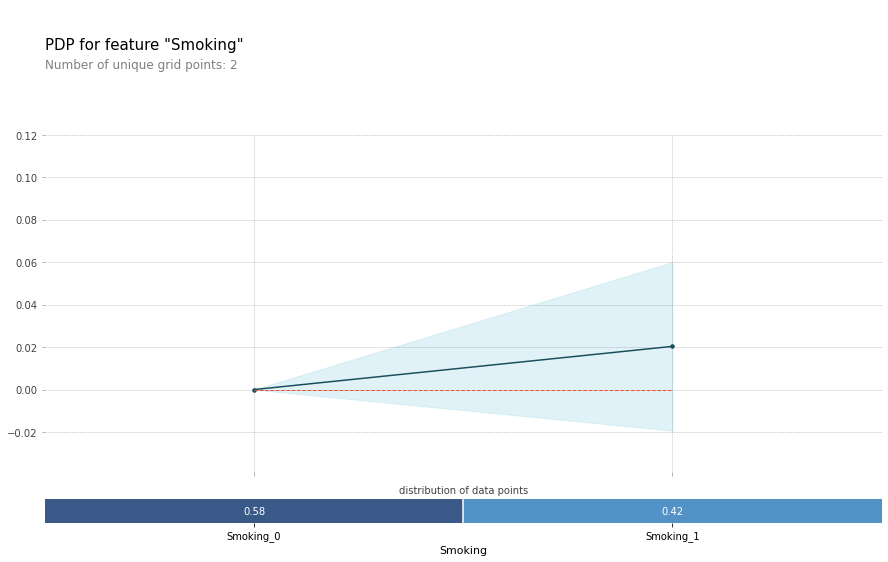

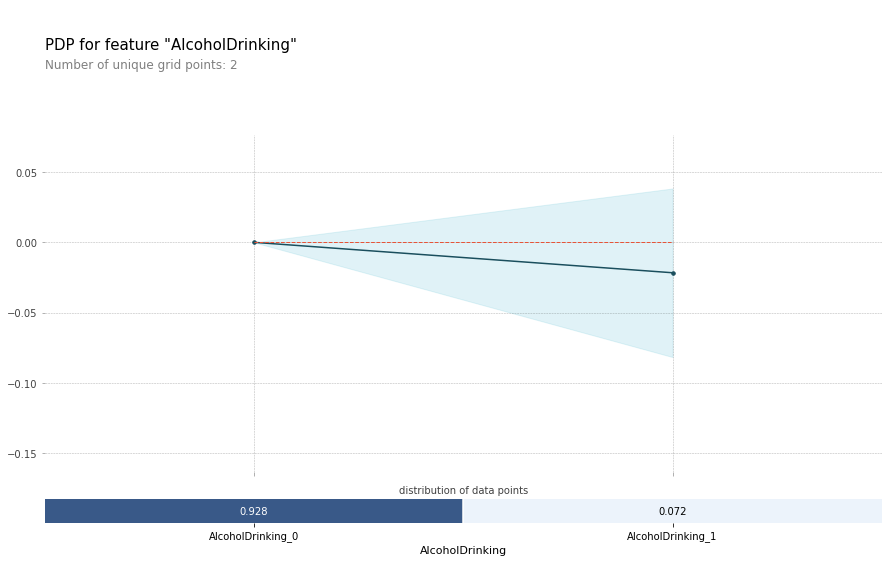

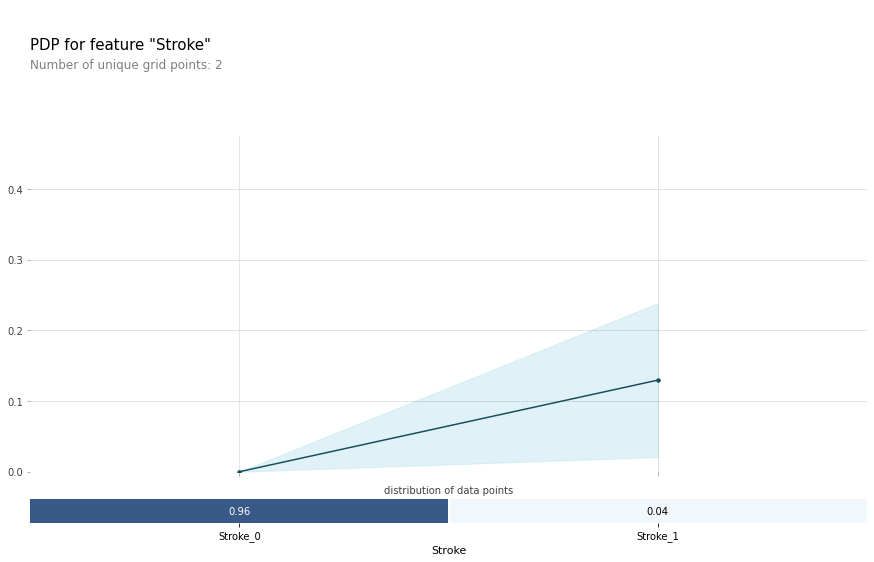

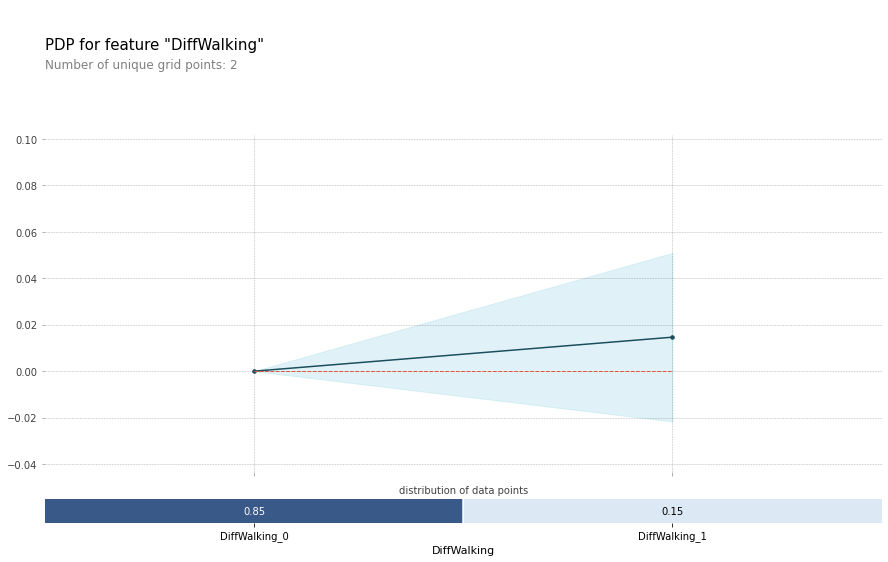

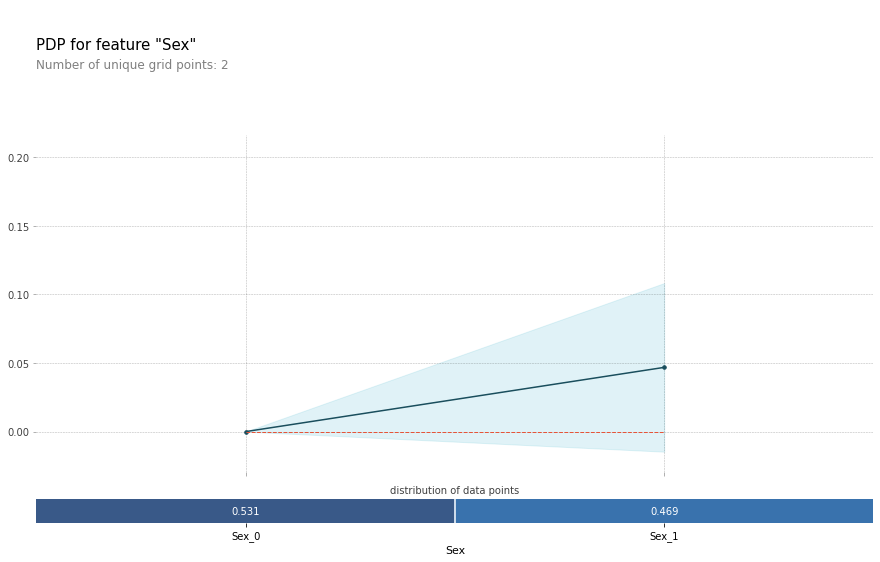

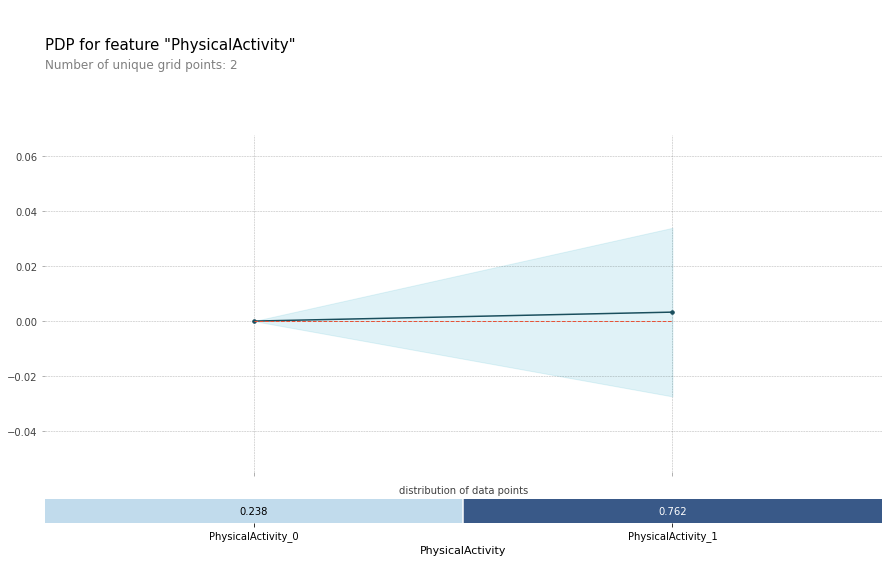

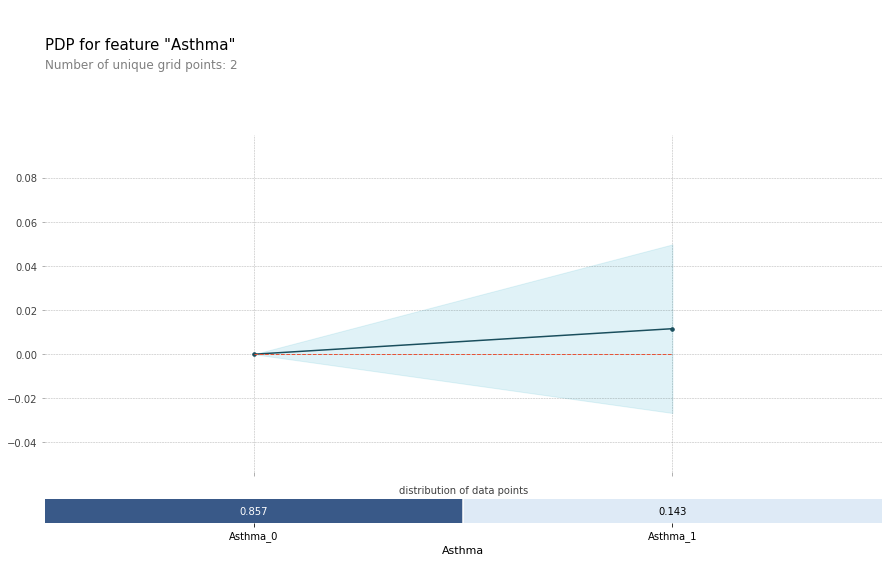

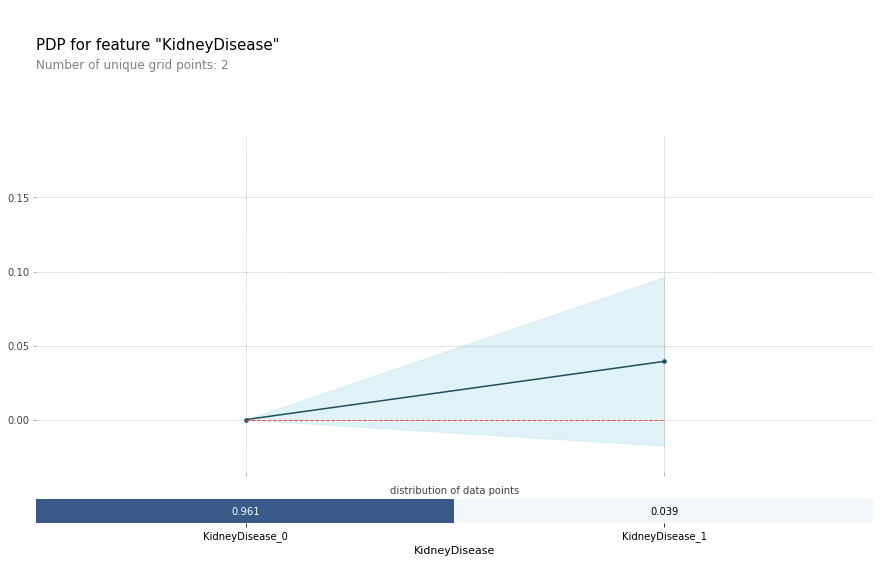

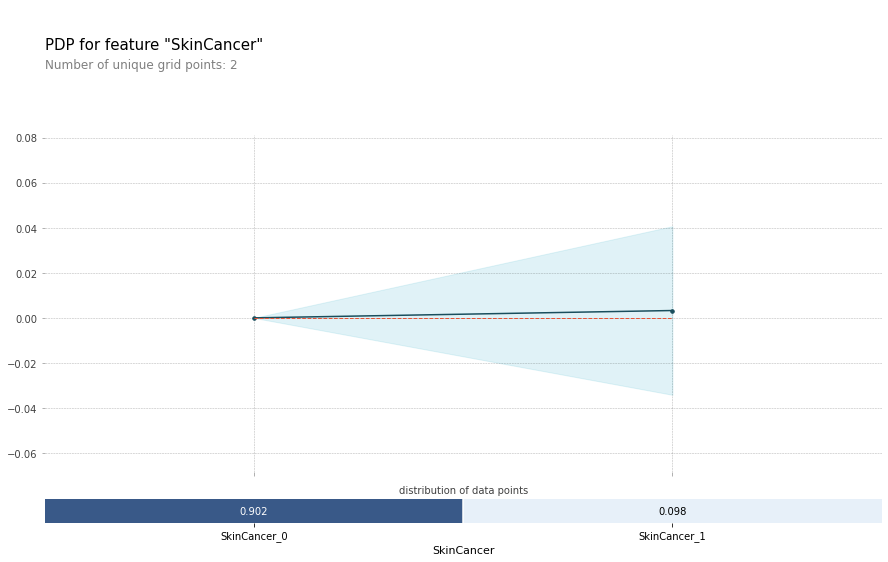

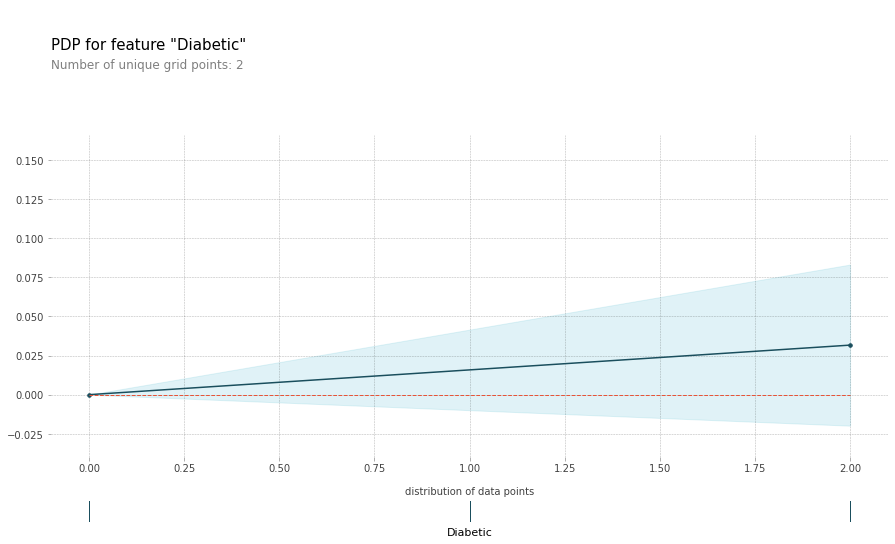

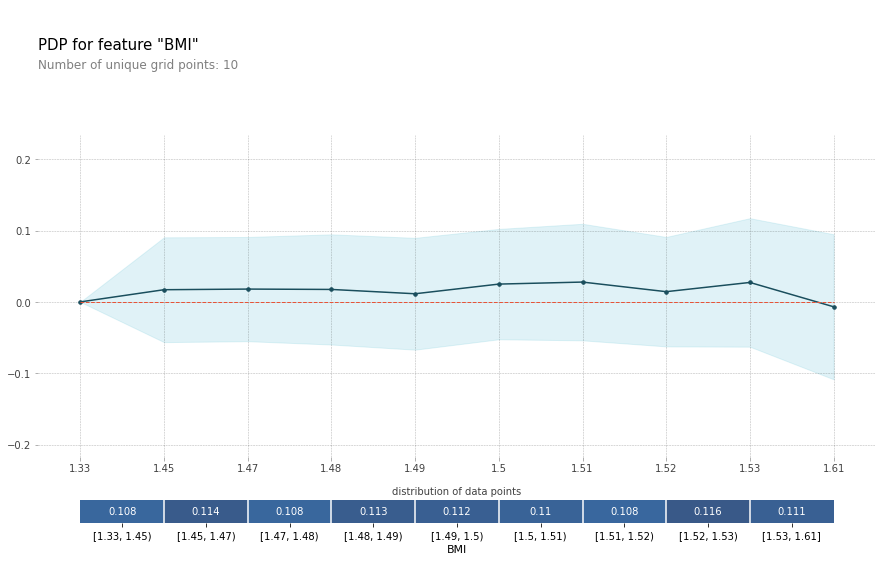

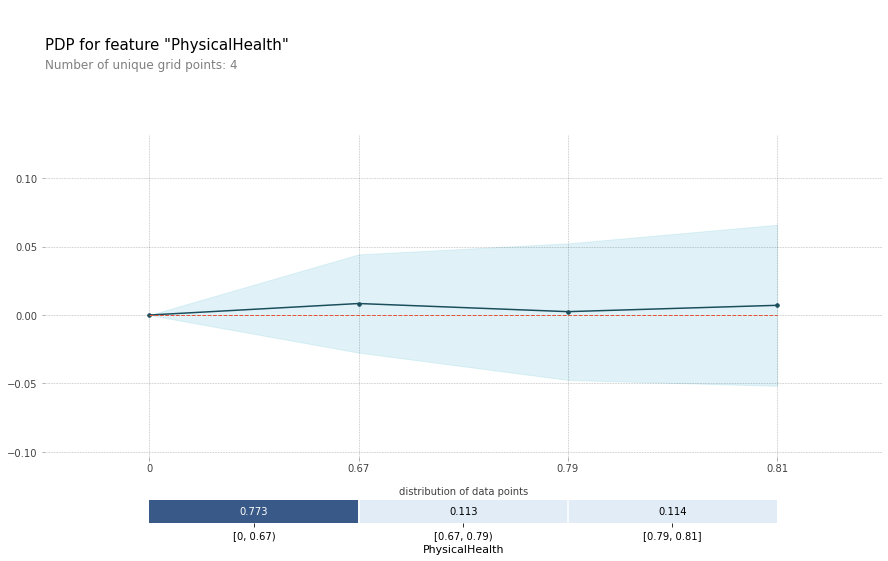

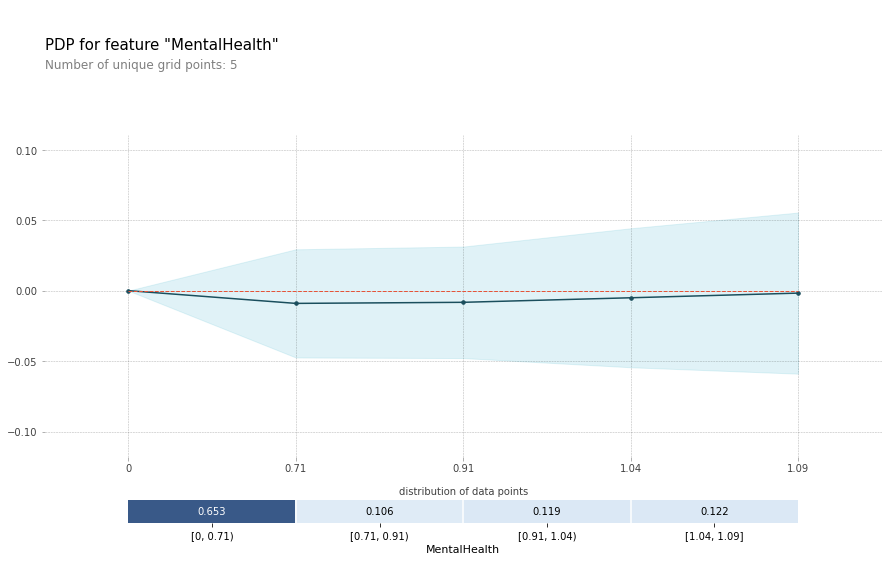

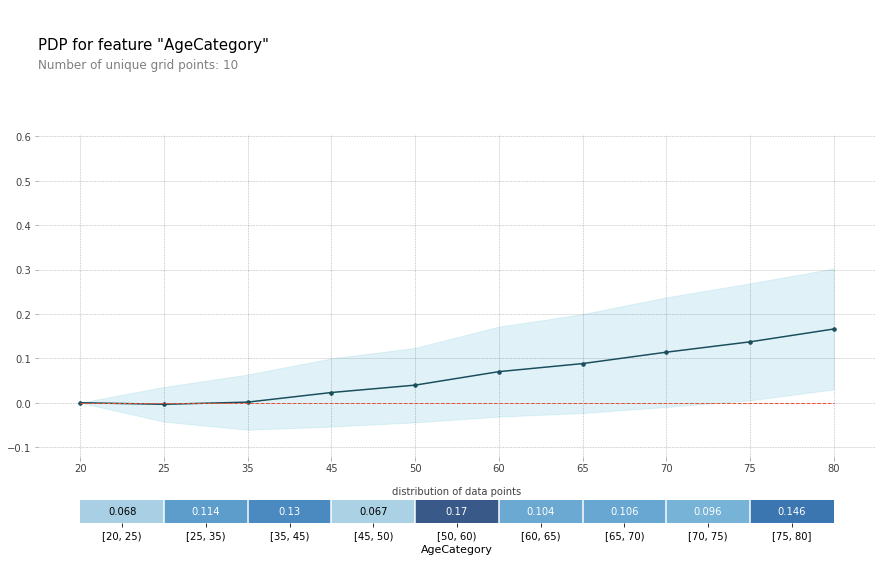

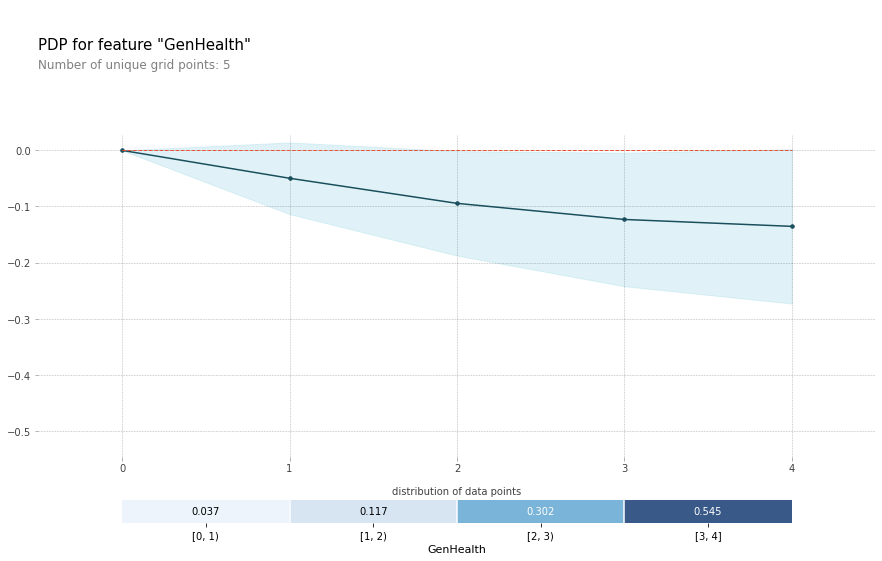

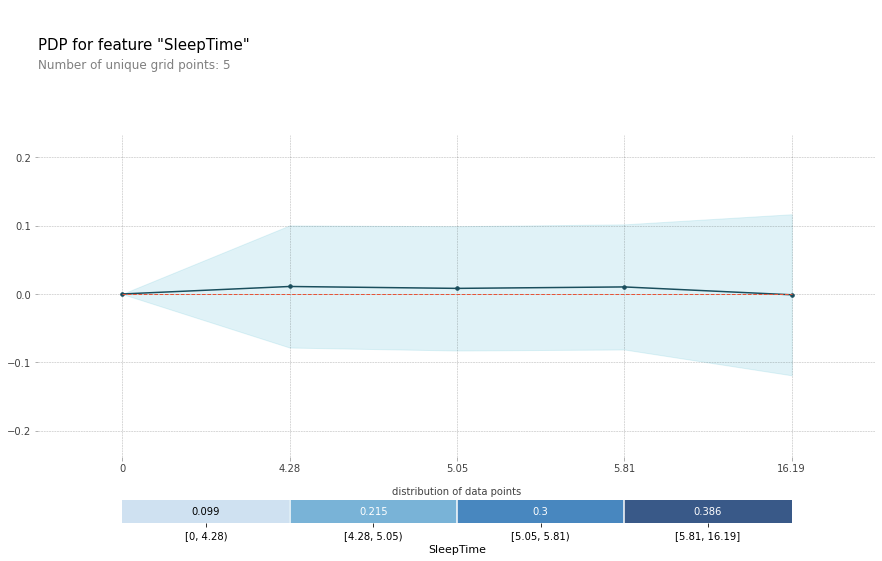

In [52]:
# 샘플링 없는 pdp
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=lgb, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i], plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=lgb, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], plot_pts_dist=True,  x_quantile=True)

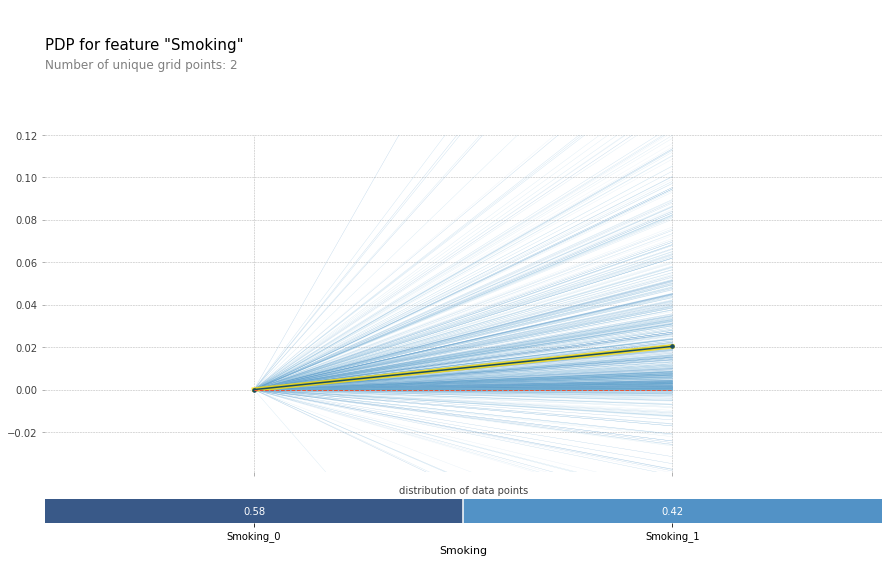

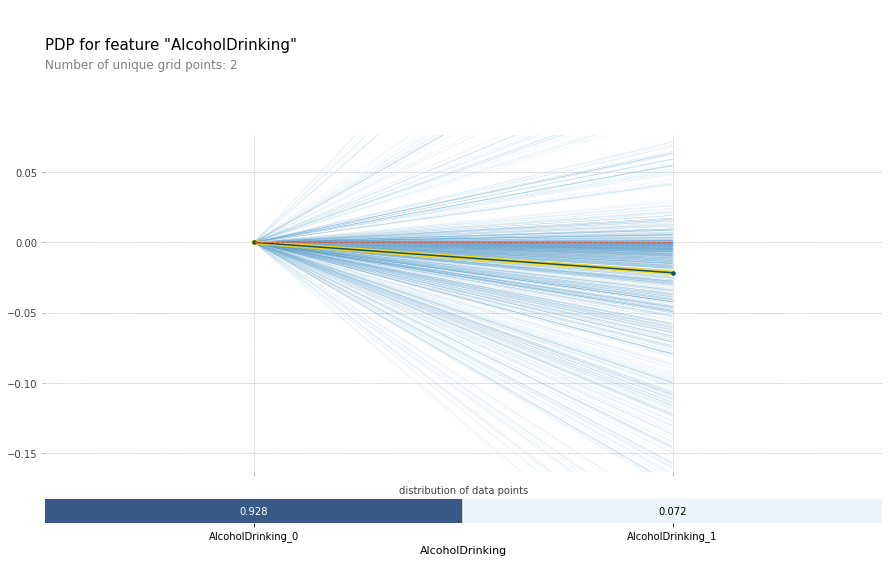

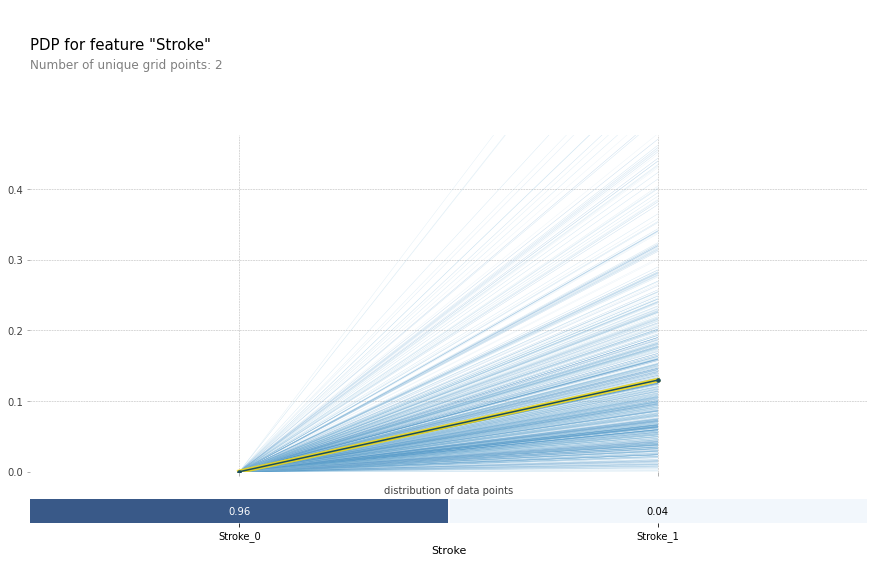

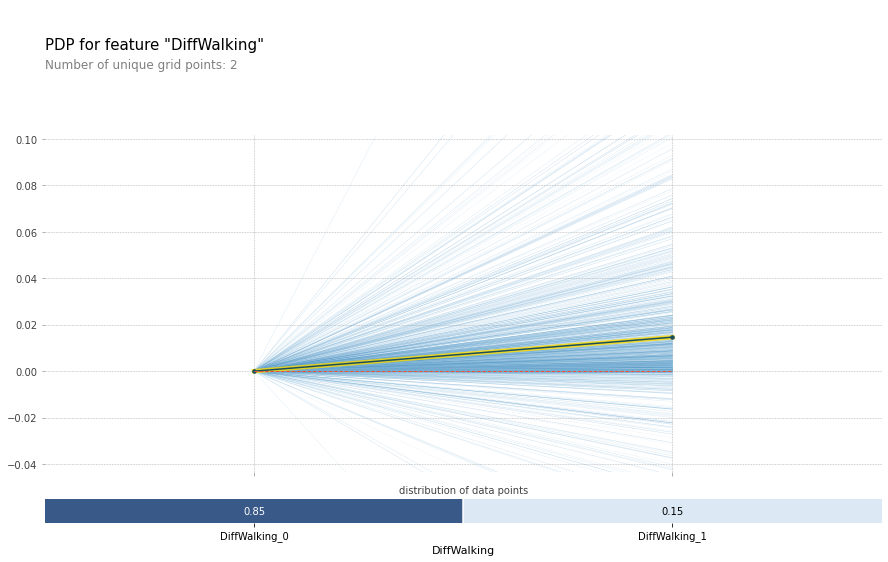

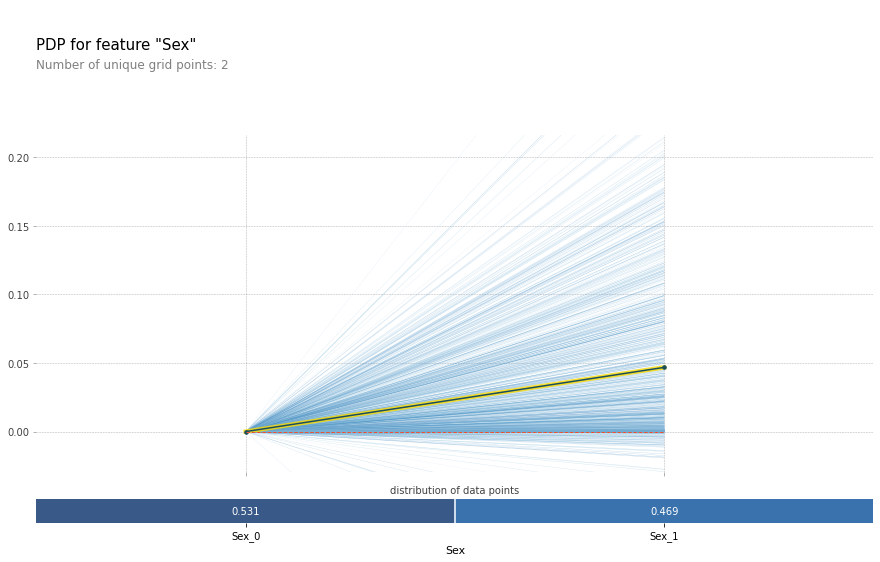

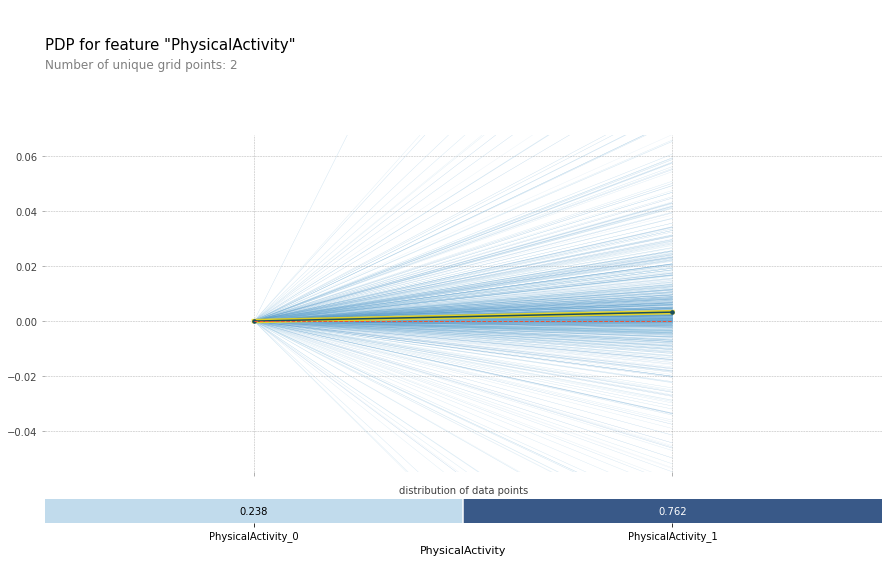

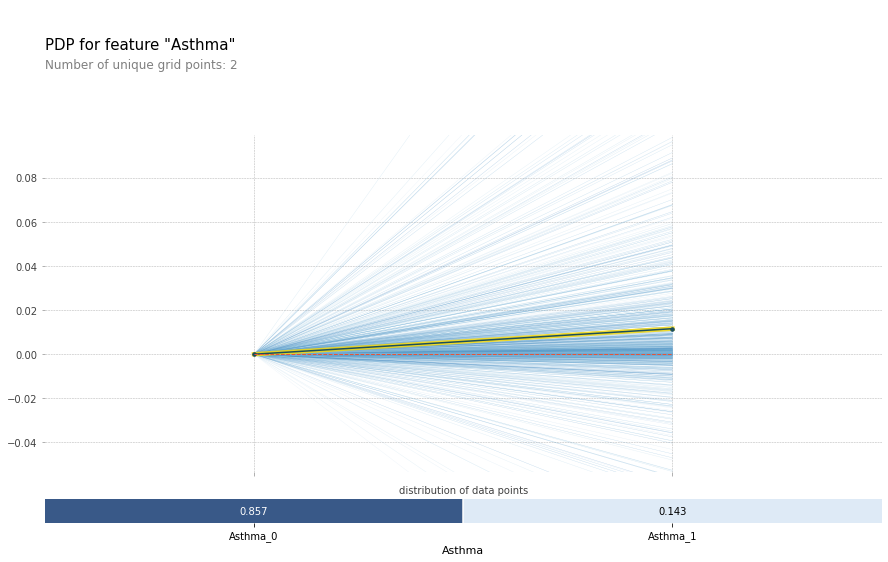

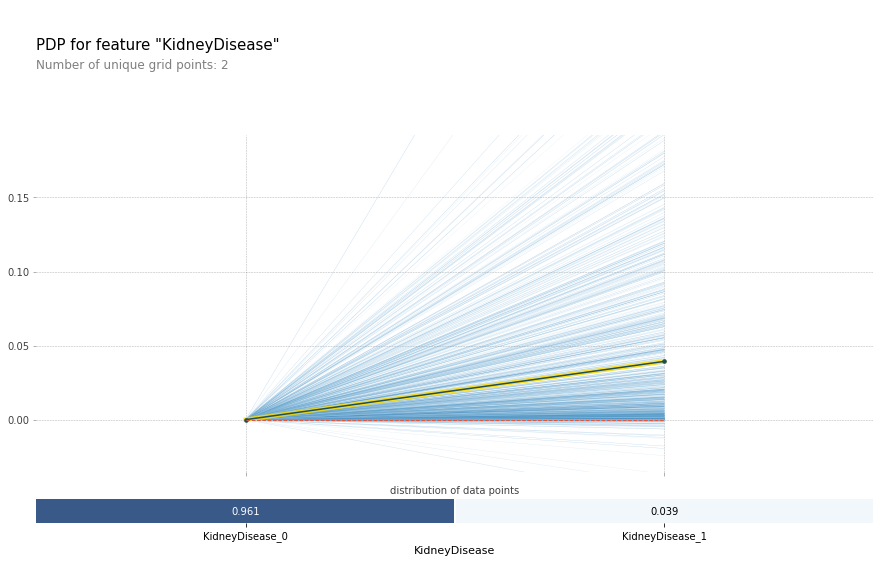

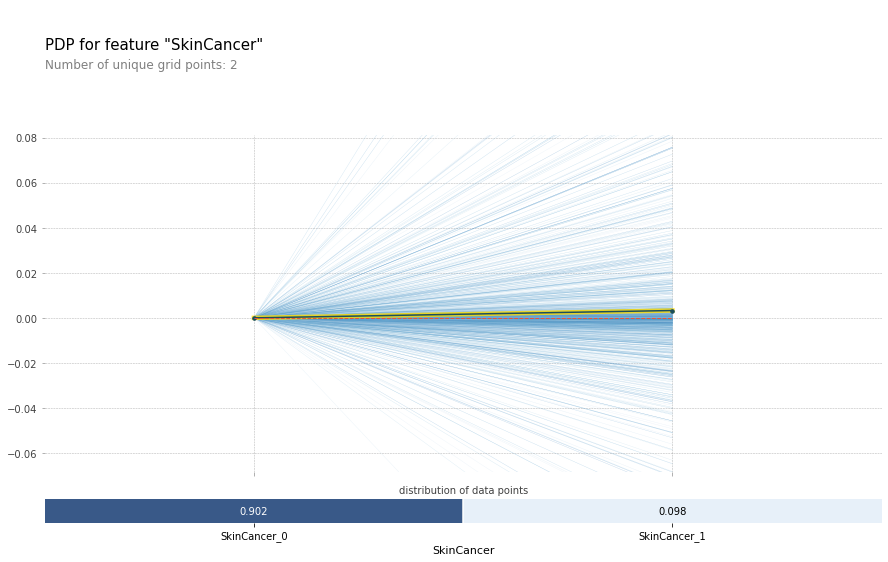

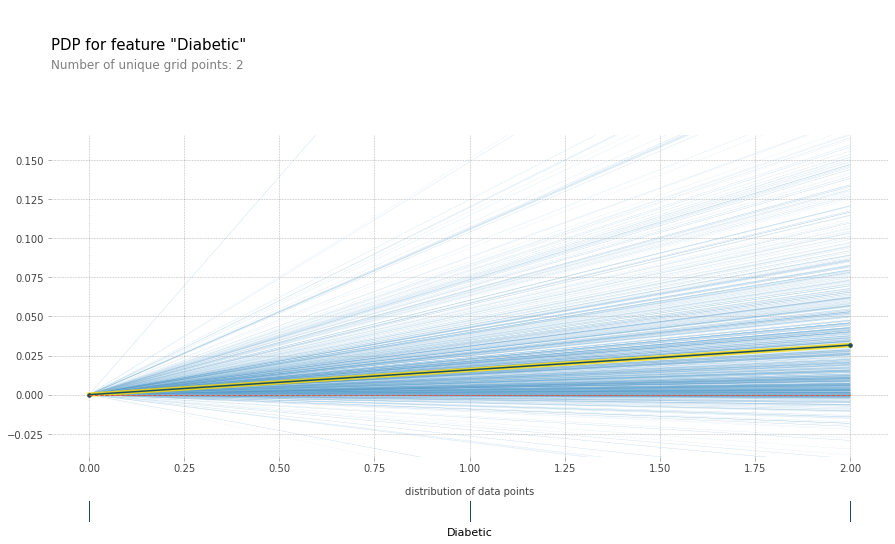

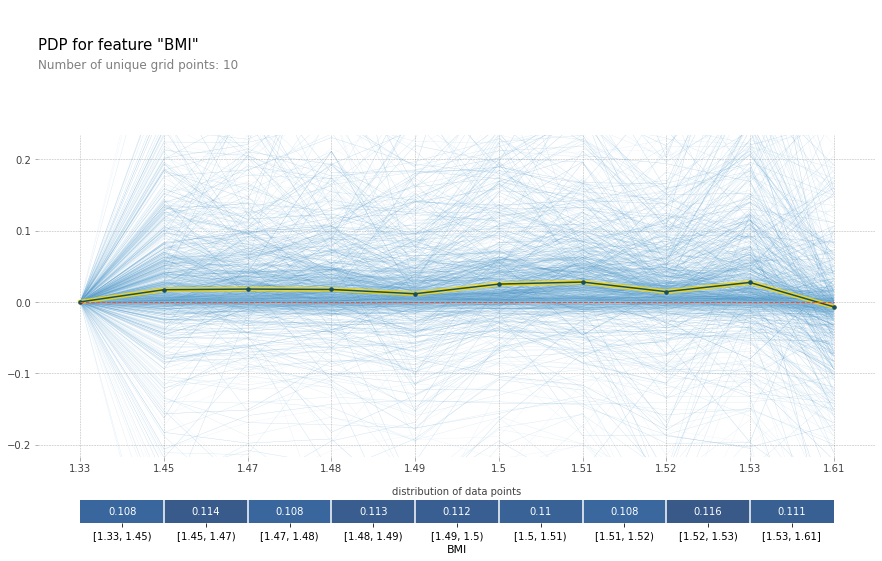

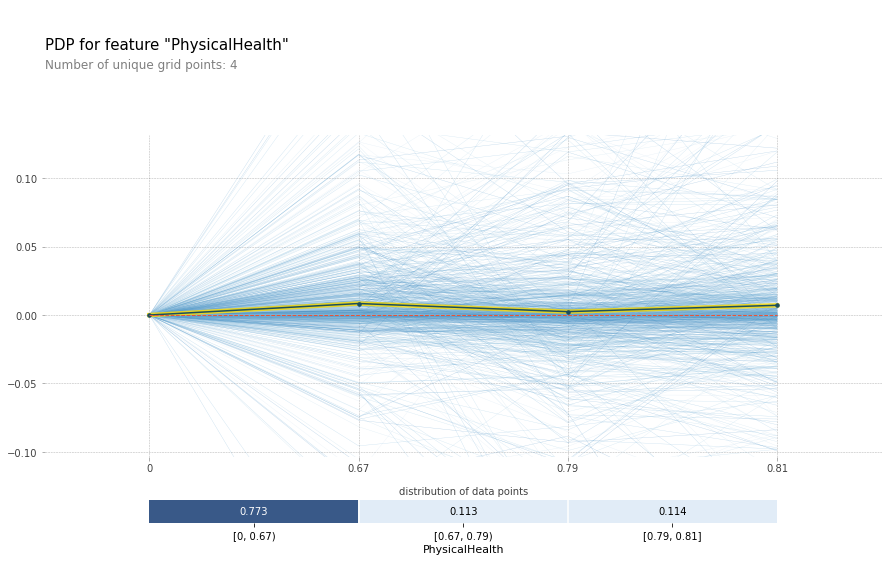

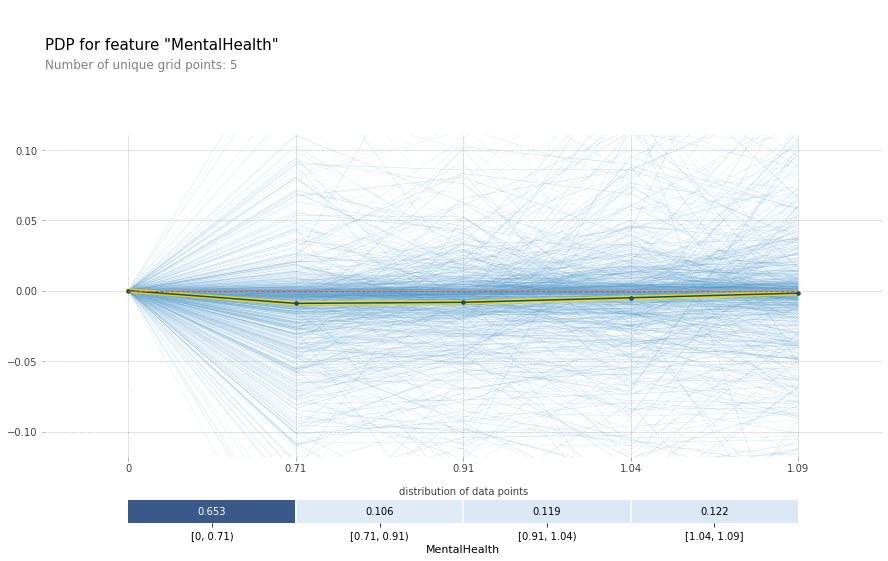

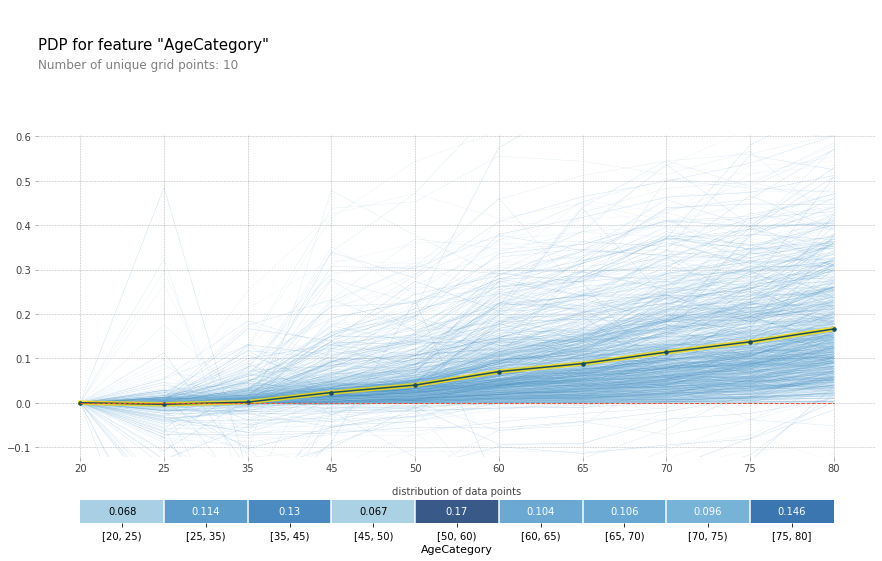

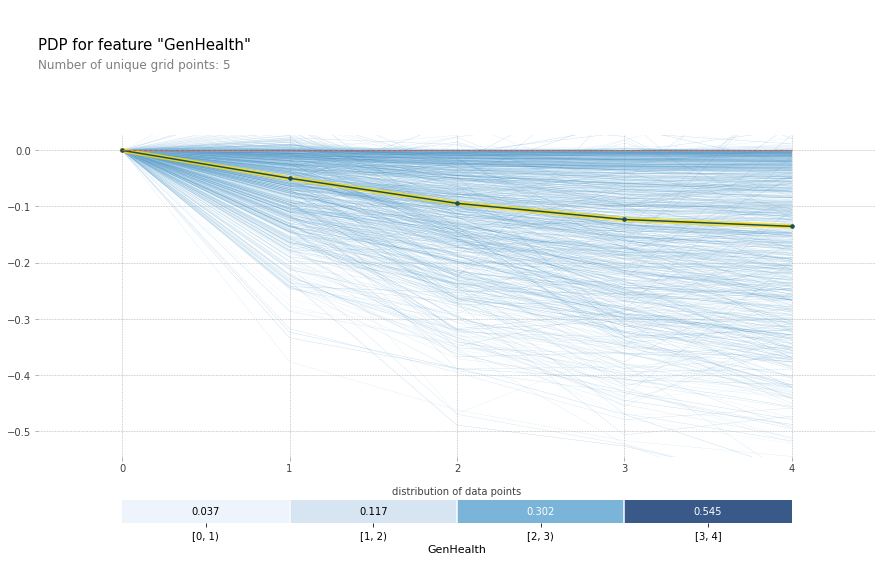

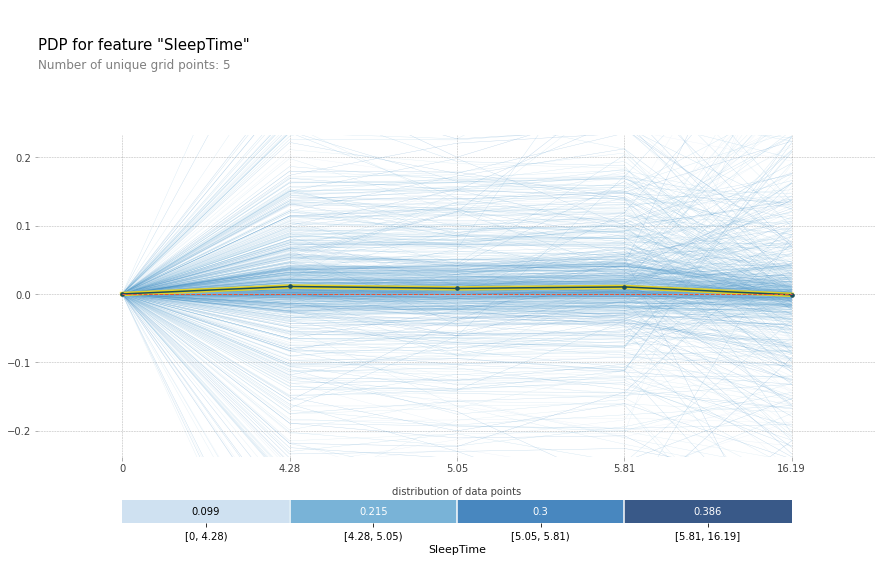

In [56]:
# 샘플링 적용안한 경우의 center ICE
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=lgb, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i],frac_to_plot=1000, plot_lines=True, plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=lgb, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], frac_to_plot=1000, plot_lines=True, plot_pts_dist=True,  x_quantile=True)

In [54]:
# SHAP
model_lgb= lgb.fit(x_train,y_train)

explainer = shap.TreeExplainer(model_lgb)
shap_values = explainer.shap_values(x_test)

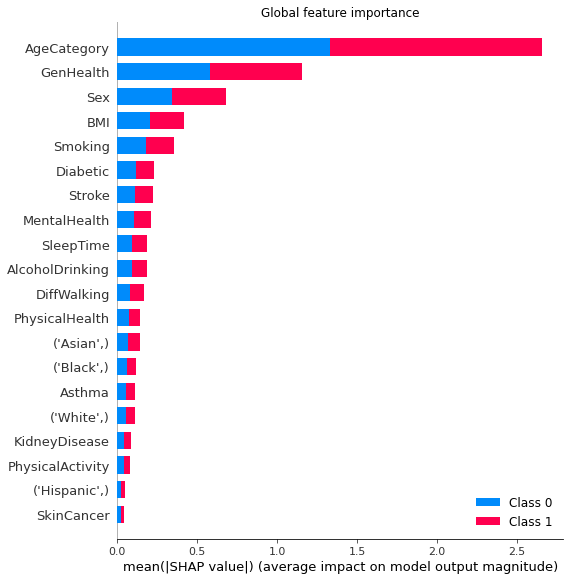

In [55]:
plt.title('Global feature importance')
shap.summary_plot(shap_values, plot_type="bar",feature_names=features)